# Environment для крестиков-ноликов

In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

In [2]:
import collections
from collections import defaultdict, deque
from tqdm.notebook import tqdm
import copy

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    # cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, actions)

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

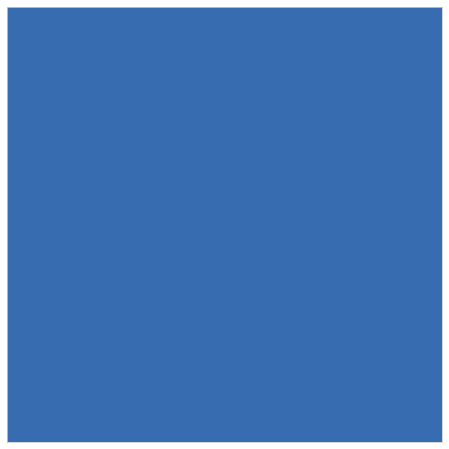

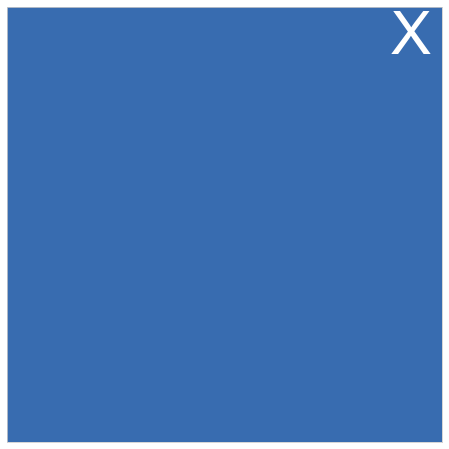

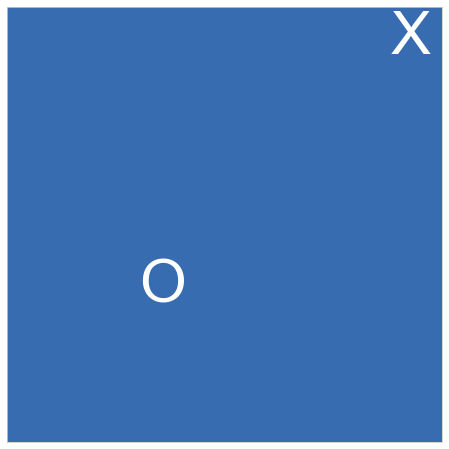

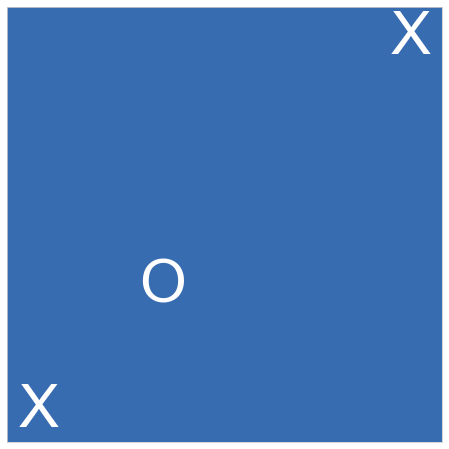

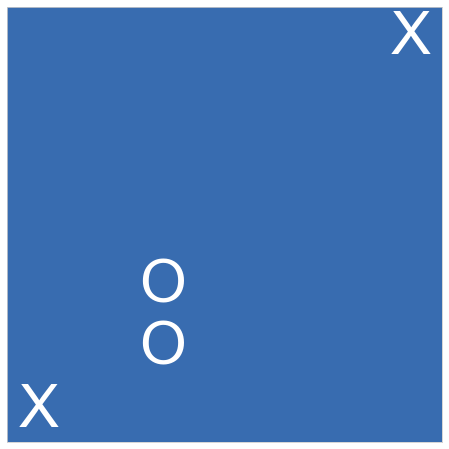

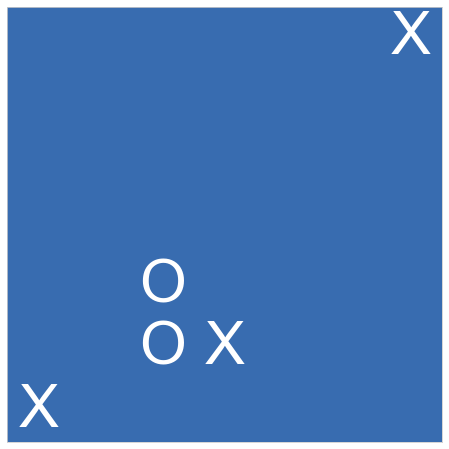

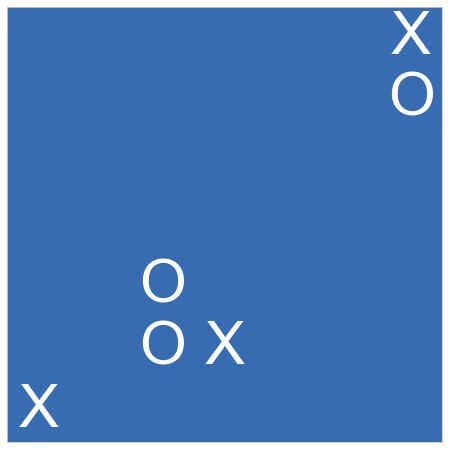

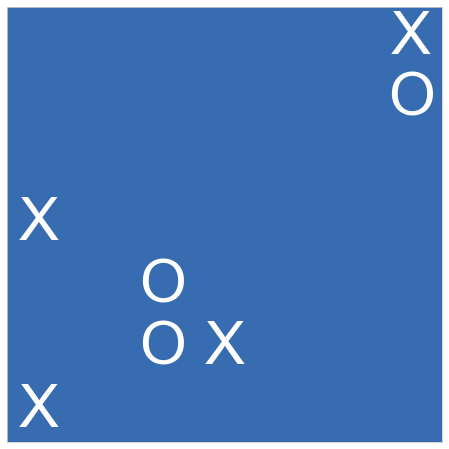

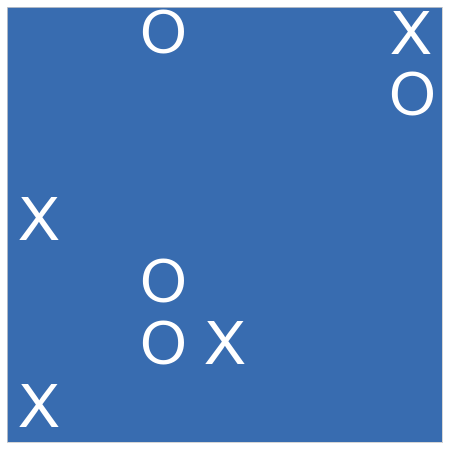

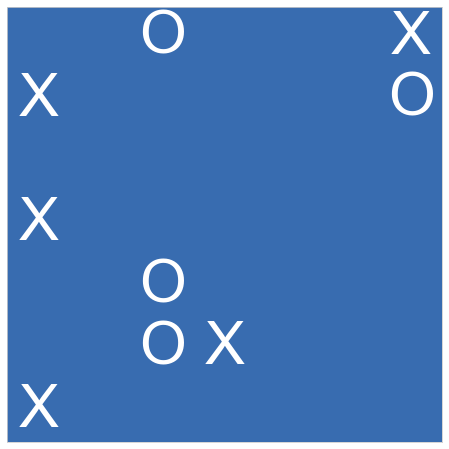

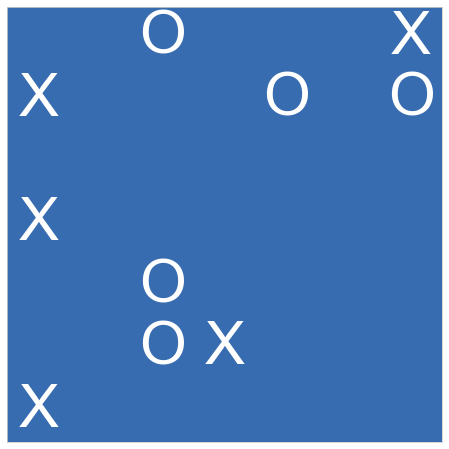

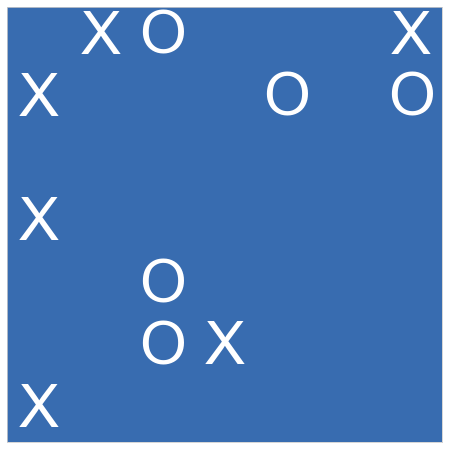

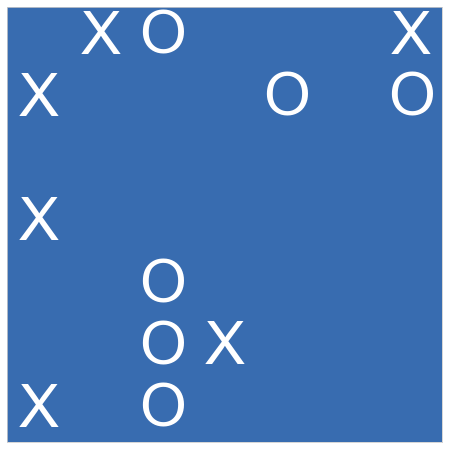

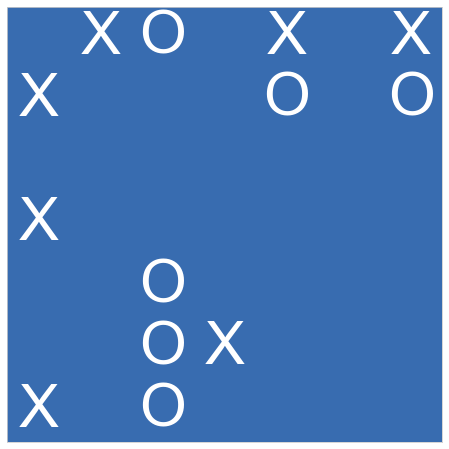

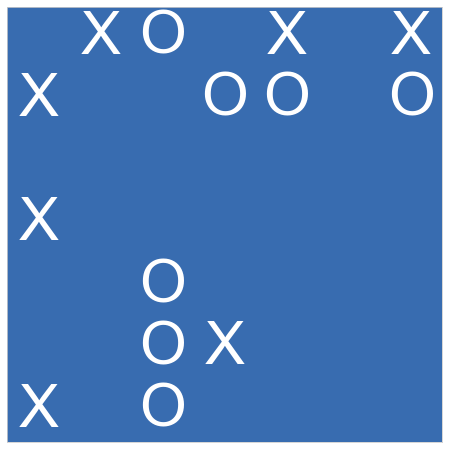

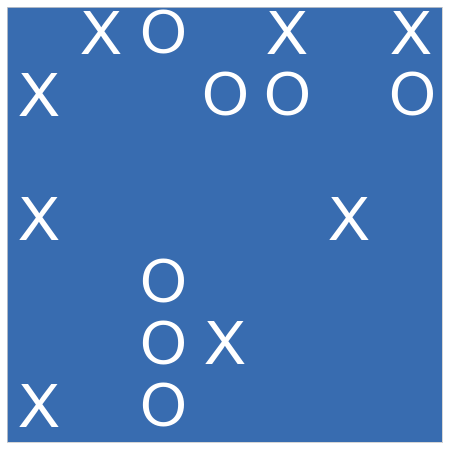

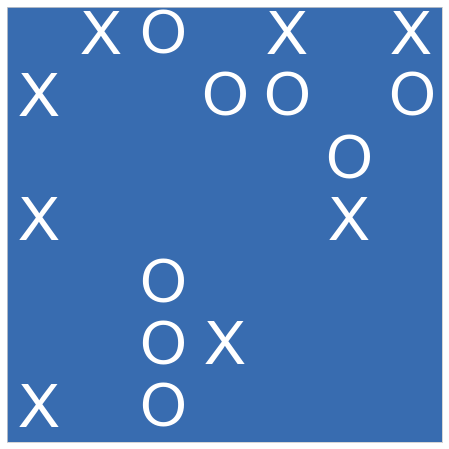

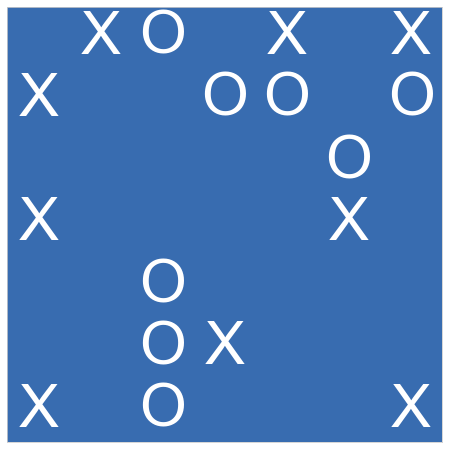

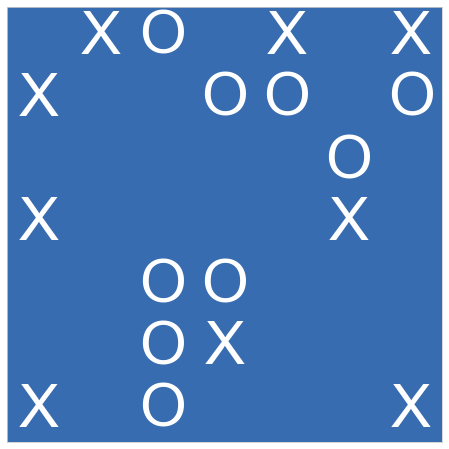

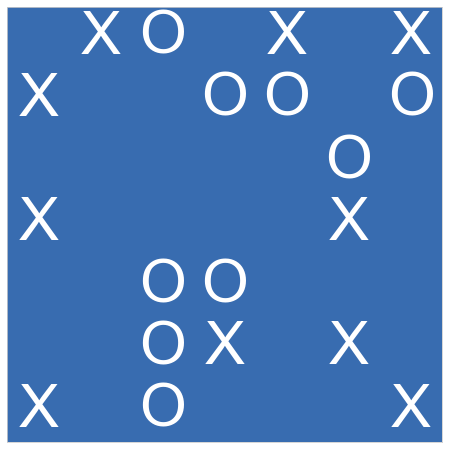

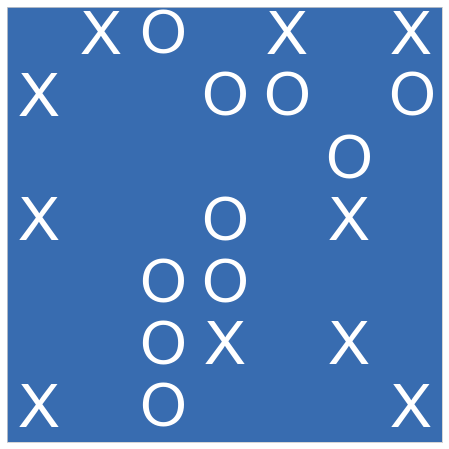

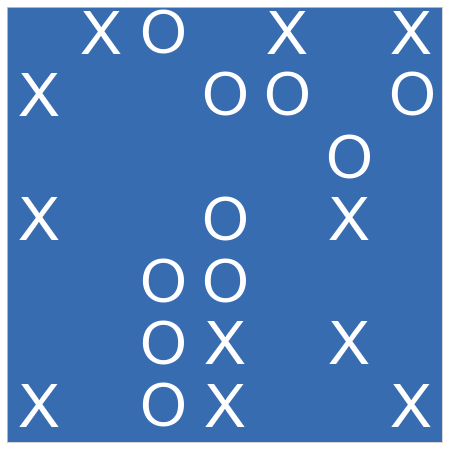

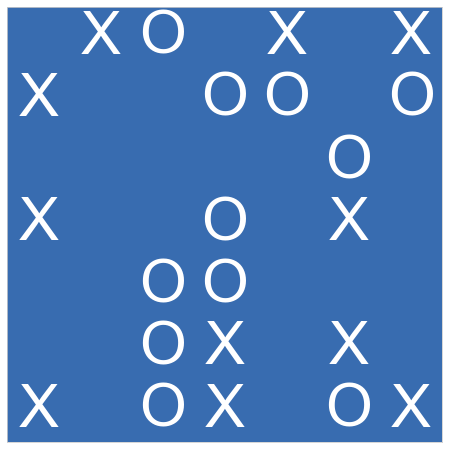

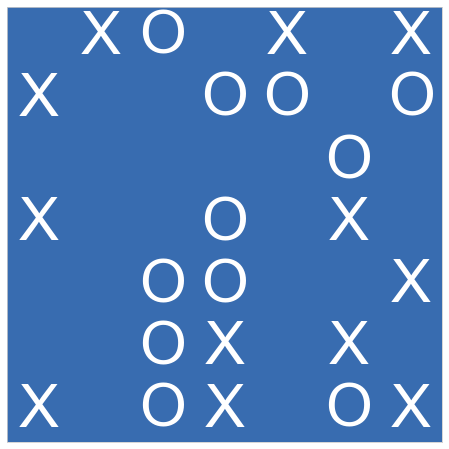

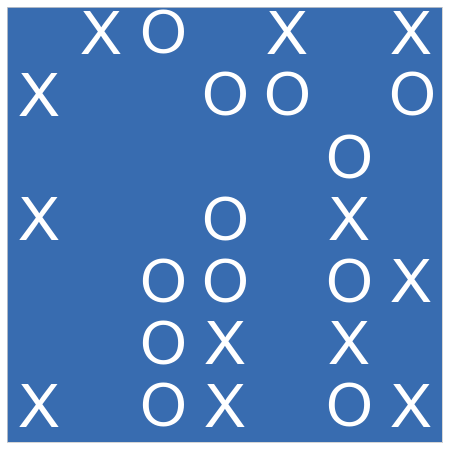

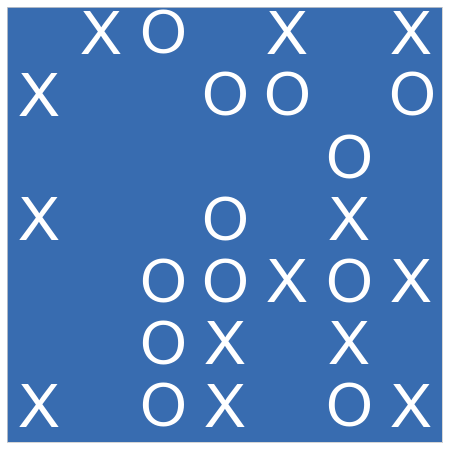

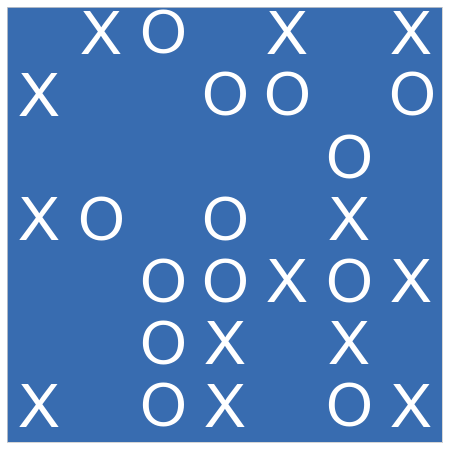

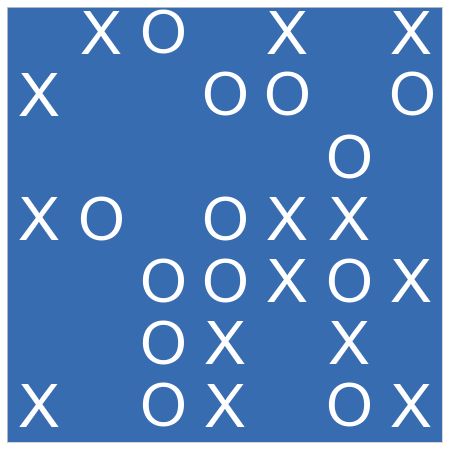

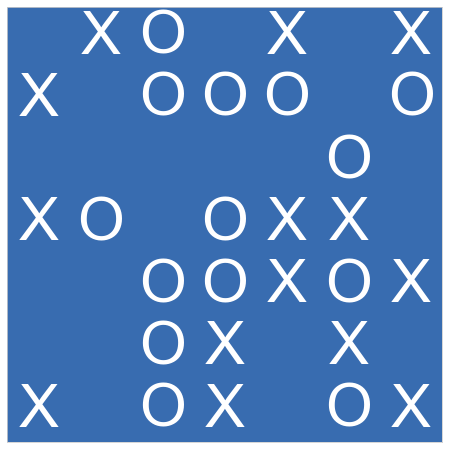

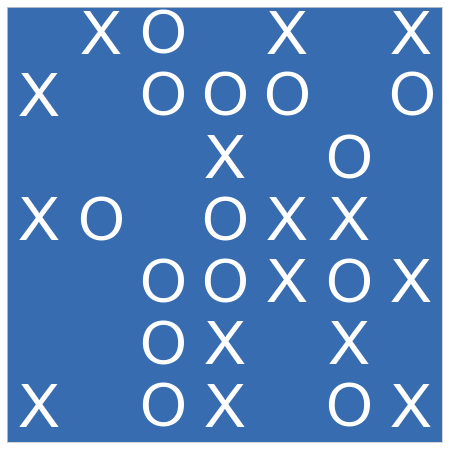

Нолики выиграли!


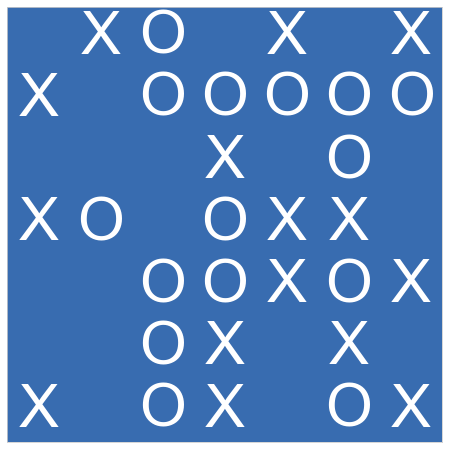

In [6]:
env = TicTacToe(n_rows=7, n_cols=7, n_win=4)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

# Часть первая: крестики-нолики при помощи Q-обучения

## 1.
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Алгоритм: Sarsamax (Q-Learning)

![title](Q_learning.png)

Чтобы я мог следить за эволюцией обученных стратегий, я буду сравнивать их со случайной стратегией.

In [7]:
def play_game(env, pi1, pi2):
    """Играем тестовую партию между стратегиями или со случайными ходами"""
    done = False
    env.reset()
    pi1_actions = [0, 0]
    pi2_actions = [0, 0]
    while not done:
        state, curTurn, actions = env.getHash(), env.curTurn, env.getEmptySpaces()
        action = None
        if curTurn == 1:
            pi1_actions[0] += 1
            if pi1 is not None:
                action = pi1[state]
                if action is not None:
                    pi1_actions[1] += 1
        else:
            pi2_actions[0] += 1
            if pi2 is not None:
                action = pi2[state]
                if action is not None:
                    pi2_actions[1] += 1
        if action is None:
            action = actions[np.random.randint(len(actions))]
        observation, reward, done, info = env.step(action)
    return reward, pi1_actions, pi2_actions

In [8]:
def take_action_by_epsilon_greedy_pi(Q, state, curTurn, actions, epsilon):
    """
    Для крестиков выбираем максимум, а для ноликов - минимум
    """
    if state in Q:
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(env.n_rows, env.n_cols))
        Q_values = np.take(Q[state], indeces)
        epsilon_greedy_pi = np.ones(len(actions)) * epsilon / len(actions)
        if curTurn == 1:
            best_a = np.argmax(Q_values)
        else:
            best_a = np.argmin(Q_values)
        epsilon_greedy_pi[best_a] = 1 - epsilon + (epsilon / len(actions))
    else:
        epsilon_greedy_pi = np.ones(len(actions)) / len(actions)  # равномерное распределение
    action_index = np.random.choice(np.arange(len(actions)), p=epsilon_greedy_pi)
    return tuple(actions[action_index])

In [9]:
def Q_learning_episode(env, Q, alpha, gamma, epsilon, curTurn):
    """
    Игру начинают крестики (env.curTurn == 1), а потом делают ход нолики (env.curTurn == -1)
    """
    done = False
    env.reset()
    while not done:
        state, env_curTurn, actions = env.getHash(), env.curTurn, env.getEmptySpaces()
        if env_curTurn != curTurn:
            # делаем ход за противника по стратегии из Q (это только первый ход) (первым ходом выиграть невозможно)
            action = take_action_by_epsilon_greedy_pi(Q, state, env_curTurn, actions, epsilon)
            _ = env.step(action)
            continue
        # делаем ход за агента которого обучаем
        action = take_action_by_epsilon_greedy_pi(Q, state, env_curTurn, actions, epsilon)
        observation, reward, done, info = env.step(action)
        observation_state, observation_curTurn = observation[0], observation[2]
        available_actions = observation[1]
        # сразу же делаем ход за противника если это возможно
        if not done:
            action_ = take_action_by_epsilon_greedy_pi(Q, observation_state, observation_curTurn, available_actions, epsilon)
            observation, reward, done, info = env.step(action_)
            observation_state, observation_curTurn = observation[0], observation[2]
            available_actions = observation[1]
        if done:
            Q[state][action] = Q[state][action] + alpha * (reward - Q[state][action])
            break
        # выбираем максимальный Q
        indeces = np.ravel_multi_index((available_actions[:, 0], available_actions[:, 1]), dims=(env.n_rows, env.n_cols))
        Q_values = np.take(Q[observation_state], indeces)
        if curTurn == 1:
            best_Q_observation = np.max(Q_values)
        else:
            best_Q_observation = np.min(Q_values)
        Q[state][action] = Q[state][action] + \
            alpha * (reward + gamma * best_Q_observation - Q[state][action])
    return reward

In [10]:
def Q_learninig(env, num_episodes=20000, alpha=0.04, gamma=0.9, init_Q=None, eps_start=1.0, eps_decay=0.99,
                eps_step=1000, eps_min=0.005):
    assert 0.0 <= eps_start <= 1.0
    if init_Q is None:
        Q = defaultdict(lambda: np.zeros((env.n_rows, env.n_cols)))
    else:
        Q = init_Q
    epsilon = eps_start
    noughts = []
    crosses = []
    for episode in tqdm(range(1, num_episodes + 1)):
        if episode % eps_step == 0:
            epsilon *= eps_decay
            epsilon = max(epsilon, eps_min)
        # (eps_step // 2) эпизодов обучаем крестики а потом (eps_step // 2) эпизодов нолики
        curTurn = (2 * ((episode // (eps_step // 2)) % 2) - 1)
        reward = Q_learning_episode(env, Q, alpha, gamma, epsilon, curTurn)
        if episode % (eps_step // 10) == 0:
            reward = Q_learning_episode(env, Q, alpha, gamma, 0, curTurn)
            if curTurn == 1:
                crosses.append(reward)
            else:
                noughts.append(reward)
        if episode % (num_episodes // 10) == 0:
            print(f"Эпизод[{episode}] epsilon={epsilon}")
            policy = defaultdict(lambda: None, 
                         dict((k, 
                               np.unravel_index(np.argmax(v) if (len([ch for ch in list(k) if ch == '1']) % 2 == (env.n_rows * env.n_cols) % 2) else np.argmin(v),
                                                (env.n_rows, env.n_cols))
                              ) for k, v in Q.items()))
            games = np.array([play_game(env, policy, None) for _ in range(100)])
            rewards, pi1_actions, _ = map(list, zip(*games))
            rewards = np.array(rewards, dtype=int)
            sum_actions = np.sum(pi1_actions, axis=0)
            print(f"Эпизод[{episode}] Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр из 100 сыгранных игр против случайной стратегии \n \
            при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")
            games = np.array([play_game(env, None, policy) for _ in range(100)])
            rewards, _, pi2_actions = map(list, zip(*games))
            rewards = np.array(rewards, dtype=int)
            sum_actions = np.sum(pi2_actions, axis=0)
            print(f"Эпизод[{episode}] Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр из 100 сыгранных игр против случайной стратегии \n \
            при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")
    # в состояниях где агент не был - возвращаем None и будем обрабатывать отдельно, когда будем играть
    policy = defaultdict(lambda: None, 
                         dict((k, 
                               np.unravel_index(np.argmax(v) if (len([ch for ch in list(k) if ch == '1']) % 2 == (env.n_rows * env.n_cols) % 2) else np.argmin(v),
                                                (env.n_rows, env.n_cols))
                              ) for k, v in Q.items()))
    noughts = np.array(noughts)
    crosses = np.array(crosses)
    games = [('0', noughts), ('X', crosses)]
    for game in games:
        y = np.convolve(np.array(game[1] == (-1 if game[0] == '0' else 1), dtype=int), np.ones(500)/500, mode='valid')
        print(y.shape)
        plt.scatter(np.arange(y.shape[0]), y)
        y = np.convolve(np.array(game[1] == 0, dtype=int), np.ones(500)/500, mode='valid')
        plt.scatter(np.arange(y.shape[0]), y)
    plt.legend(['0 Win', '0 Draw', 'X Win', 'X Draw'], loc='upper left')
    plt.title("Q-learning agent versus Q-learning agent")
    plt.show()
    return policy, Q, noughts, crosses

Эпизод[10000] epsilon=0.9047921471137096
Эпизод[10000] Агент играя за крестики выигрывает 93 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[10000] Агент играя за нолики выигрывает 81 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.015772870662460567 процентах случаев
Эпизод[20000] epsilon=0.818648829478636
Эпизод[20000] Агент играя за крестики выигрывает 97 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[20000] Агент играя за нолики выигрывает 80 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[30000] epsilon=0.7407070321560997
Эпизод[30000] Агент играя за крестики выигрывает 98 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах слу

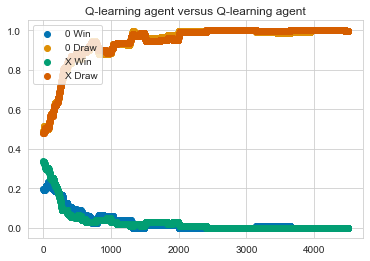

In [47]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
policy, Q, noughts, crosses = Q_learninig(env, num_episodes=100000, alpha=0.05, gamma=0.9, init_Q=None, eps_start=1.0, eps_decay=0.999,
                eps_step=100, eps_min=0.05)

Видим, что в конце два агента так хороши, что играют только в ничью (между собой).

Посмотрим как крестики играют против случайной стратегии и как нолики играют против случайной стратегии

In [48]:
games = np.array([play_game(env, policy, None) for _ in range(10000)])
rewards, pi1_actions, _ = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi1_actions, axis=0)
print(f"Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр, проигрывает {int(np.sum(rewards == -1))} из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

games = np.array([play_game(env, None, policy) for _ in range(10000)])
rewards, _, pi2_actions = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi2_actions, axis=0)
print(f"Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр, проигрывает {int(np.sum(rewards == 1))}  из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

Агент играя за крестики выигрывает 9907 игр, проигрывает 0 из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.0 процентах случаев
Агент играя за нолики выигрывает 8886 игр, проигрывает 0  из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.0 процентах случаев


Нолики, выигрывают реже, потому что в игре крестики-нолики у крестиков есть преимущество (ходят первыми).

## 2.
Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Эпизод[50000] epsilon=0.7787520933134615
Эпизод[50000] Агент играя за крестики выигрывает 85 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.09467455621301775 процентах случаев
Эпизод[50000] Агент играя за нолики выигрывает 19 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.270516717325228 процентах случаев
Эпизод[100000] epsilon=0.606454822840097
Эпизод[100000] Агент играя за крестики выигрывает 100 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.0 процентах случаев
Эпизод[100000] Агент играя за нолики выигрывает 18 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.189873417721519 процентах случаев
Эпизод[150000] epsilon=0.4722779627867691
Эпизод[150000] Агент играя за крестики выигрывает 100 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не зн

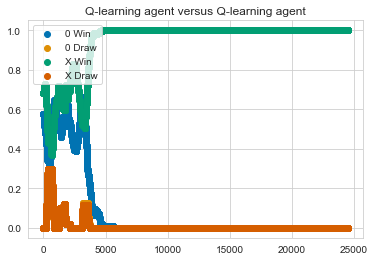

In [49]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
policy, Q, noughts, crosses = Q_learninig(env, num_episodes=500000, alpha=0.05, gamma=0.99, init_Q=None, eps_start=1.0, eps_decay=0.9995,
                eps_step=100, eps_min=0.05)

Кажется, что на доске 4 на 4 у ноликов нет шансов.

Посмотрим как крестики играют против случайной стратегии и как нолики играют против случайной стратегии

In [51]:
games = np.array([play_game(env, policy, None) for _ in range(10000)])
rewards, pi1_actions, _ = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi1_actions, axis=0)
print(f"Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр, проигрывает {int(np.sum(rewards == -1))} из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

games = np.array([play_game(env, None, policy) for _ in range(10000)])
rewards, _, pi2_actions = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi2_actions, axis=0)
print(f"Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр, проигрывает {int(np.sum(rewards == 1))}  из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

Агент играя за крестики выигрывает 10000 игр, проигрывает 0 из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.0 процентах случаев
Агент играя за нолики выигрывает 2598 игр, проигрывает 1609  из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.18119050811100684 процентах случаев


Для доски 4 на 4, по-видимому, преимущество крестиков еще сильнее, чем это было на доске 3 на 3.

Эпизод[50000] epsilon=0.7787520933134615
Эпизод[50000] Агент играя за крестики выигрывает 21 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.20391061452513967 процентах случаев
Эпизод[50000] Агент играя за нолики выигрывает 20 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.3834808259587021 процентах случаев
Эпизод[100000] epsilon=0.606454822840097
Эпизод[100000] Агент играя за крестики выигрывает 65 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.22606382978723405 процентах случаев
Эпизод[100000] Агент играя за нолики выигрывает 25 игр из 100 сыгранных игр против случайной стратегии 
             при этом он не знает что делать в 0.4430992736077482 процентах случаев
Эпизод[150000] epsilon=0.4722779627867691
Эпизод[150000] Агент играя за крестики выигрывает 90 игр из 100 сыгранных игр против случайной стратегии 
             п

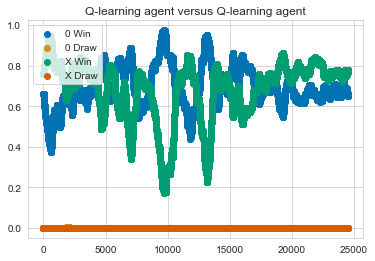

In [11]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)
policy, Q, noughts, crosses = Q_learninig(env, num_episodes=500000, alpha=0.05, gamma=0.99, init_Q=None, eps_start=1.0, eps_decay=0.9995,
                eps_step=100, eps_min=0.05)

Посмотрим как крестики играют против случайной стратегии и как нолики играют против случайной стратегии

In [12]:
games = np.array([play_game(env, policy, None) for _ in range(10000)])
rewards, pi1_actions, _ = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi1_actions, axis=0)
print(f"Агент играя за крестики выигрывает {int(np.sum(rewards == 1))} игр, проигрывает {int(np.sum(rewards == -1))} из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

games = np.array([play_game(env, None, policy) for _ in range(10000)])
rewards, _, pi2_actions = map(list, zip(*games))
rewards = np.array(rewards, dtype=int)
sum_actions = np.sum(pi2_actions, axis=0)
print(f"Агент играя за нолики выигрывает {int(np.sum(rewards == -1))} игр, проигрывает {int(np.sum(rewards == 1))}  из 10000 сыгранных игр против случайной стратегии \n \
при этом он не знает что делать в {(sum_actions[0] - sum_actions[1]) / sum_actions[0]} процентах случаев")

Агент играя за крестики выигрывает 9637 игр, проигрывает 103 из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.020086037831340546 процентах случаев
Агент играя за нолики выигрывает 3011 игр, проигрывает 3623  из 10000 сыгранных игр против случайной стратегии 
 при этом он не знает что делать в 0.4750336211010368 процентах случаев


Странно, что при обучении крестики и нолики играют практически одинаково, но против случайной стратегии нолики играют слабее. С доской 4 на 4 нолики и при обучении были слабее крестиков.

# Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).


## 3.
Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Мой текущий код стратегий не расширяется, поэтому перепишу его.

In [43]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)
        self.reward_mode = False

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size, eps=None, reward=False):
        if reward:
            if not self.reward_mode:
                self.reward_mode = True
                self.reward_memory = [item for item in self.memory if item.reward != 0]
                self.not_reward_memory = [item for item in self.memory if item.reward == 0]
                # print(f"Length reward_memory={len(self.reward_memory)}; length not_reward_memory={len(self.not_reward_memory)}")
            reward_sample = random.sample(self.reward_memory, min(len(self.reward_memory), int(batch_size * eps)))
            not_reward_sample = random.sample(self.not_reward_memory, batch_size - len(reward_sample))
            return [*reward_sample, *not_reward_sample]
        else:
            self.reward_mode = False
            return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [44]:
class DQNNetwork(nn.Module):
    # раньше использовал BatchNorm, но он сильно замедлил работу сети, потому что с ним нужно использовать model.eval() и model.train()
    def __init__(self, hidden_channels=10):
        nn.Module.__init__(self)
        self.l1 = nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l3 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l4 = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [45]:
class model_dict(collections.UserDict):
    def __init__(self, model=None, converter=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.converter = converter

    def __missing__(self, key):
        if self.model is None:
            raise KeyError(key)
        if key not in self:
            with torch.no_grad():
                self[key] = self.model(self.converter(key))[0, 0].detach().numpy()
        return self[key]
        
class DQNTicTacAgent():
    def __init__(self, learning_rate=1e-3, n_rows=3, n_cols=3):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = DQNNetwork(hidden_channels=10).to(self.device)
        self.crosses_memory = ReplayMemory(2000)
        self.noughts_memory = ReplayMemory(2000)
        self.optimizer = optim.Adam(self.model.parameters(), learning_rate, weight_decay=1e-5)
        self.steps_done = { -1: 0, 1: 0 }
        
        self.trainable = True
        self.gamma = 0.99
        self.batch_size = 512
        
        self.eps, self.eps_final, self.eps_step, self.eps_decay = { -1: 1.0, 1: 1.0 }, 0.05, 100, 0.99
        self.sessions = { -1: [], 1: [] }
        self.n_rows = n_rows
        self.n_cols = n_cols
        
    def getSideFromState(self, state):
        if (np.sum(state == 0) % 2 == (self.n_rows * self.n_cols) % 2):
            return 1
        else:
            return -1
        
    def getActionGreedy(self, state, actions):
        """
        Возвращем индекс лучшего действия
        """
        side = self.getSideFromState(state)
        state = self.convertState(state)
        with torch.no_grad():
            Q_state = self.model(state.to(self.device))[0, 0].detach().cpu().numpy()
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
        Q_values = np.take(Q_state, indeces)
        if side == 1:
            action_index = np.argmax(Q_values)
        else:
            action_index = np.argmin(Q_values)
        return actions[action_index]
    
    @property
    def Q(self):
        """
        Возвращаем Q таблицу
        """
        return model_dict(self.model, self.convertState)
    
    def getAction(self, state, actions, side):
        """
        Возвращает позицию на которую нужно поставить крестик/нолик.
        Действие выбираем с учетом эпсилон.
        """
        # облегчил логику то как выбирается действие (чтобы ускорить подсчет)
        random_value = random.random()
        if random_value < self.eps[side]:
            action_index = random.randrange(len(actions))
        else:
            with torch.no_grad():
                Q_state = self.model(state.to(self.device))[0, 0].detach().cpu().numpy()
            # ищем индекс где
            indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
            Q_values = np.take(Q_state, indeces)
            if side == 1:
                action_index = np.argmax(Q_values)
            else:
                action_index = np.argmin(Q_values)
        return actions[action_index]
        
    def convertState(self, state):
        convertedState = torch.tensor(state, dtype=torch.float32)[None, None, :, :]
        return convertedState
    
    def checkSessionHistory(self, side):
        if len(self.sessions[side]) == 2:
            # если в истории сесии есть два события, то добавим их в память
            state, action, _ = self.sessions[side][0]
            self.sessions[side] = self.sessions[side][1:]
            next_state, _, reward = self.sessions[side][0]

            action = self.n_rows * action[0] + action[1]
            action = torch.tensor([action])[None, :]
            reward = torch.tensor([reward])[None, :]

            record = (state, action, next_state, reward)
            if side == 1:
                self.crosses_memory.push(*record)
            else:
                self.noughts_memory.push(*record)
    
    def move(self, env, side):
        state, actions = env.board, env.getEmptySpaces()
        state = self.convertState(state)
        action = self.getAction(state, actions, side)
        _, reward, done, _ = env.step(action)
        # добавляем новую тройку в историю сесии
        self.sessions[side].append((state, action, 0))
        self.checkSessionHistory(side)
        if self.trainable:
            self.learn(side)
        return reward, done
    
    def learn(self, side, reward=False):
        if side == 1:
            memory = self.crosses_memory
        else:
            memory = self.noughts_memory
        if len(memory) < 2 * self.batch_size:
            return
        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size, eps=self.eps[side], reward=reward)
        batch = Transition(*zip(*transitions))
        batch_state = Variable(torch.cat(batch.state)).to(self.device)
        batch_action = Variable(torch.cat(batch.action)).to(self.device)
        batch_reward = Variable(torch.cat(batch.reward)).to(self.device)
        batch_next_state = Variable(torch.cat(batch.next_state)).to(self.device)
        # считаем значения функции Q
        Q = self.model(batch_state).view(self.batch_size, -1).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        with torch.no_grad():
            Qmax = self.model(batch_next_state).detach()
        if side == 1:
            Qmax[batch_next_state != 0] = -10**9
            Qmax = Qmax.view(self.batch_size, -1).max(1)[0]
        else:
            Qmax[batch_next_state != 0] = 10**9
            Qmax = Qmax.view(self.batch_size, -1).min(1)[0]
        Qmax[batch_reward.view(-1) != 0] = 0
        Qnext = batch_reward.reshape([self.batch_size]) + (self.gamma * Qmax)
        Qnext = torch.clamp(Qnext, -1, 1)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def newGame(self, side):
        self.steps_done[side] += 1
        if self.steps_done[side] % self.eps_step == 0:
            self.eps[side] *= self.eps_decay
            self.eps[side] = max(self.eps[side], self.eps_final)
        self.sessions[side] = []
        return side
    
    def endGame(self, env, result, side):
        state = env.board
        state = self.convertState(state)
        # добавить новое состояние в сессию
        self.sessions[side].append((state, None, result))
        # сформировать новую пару ('state', 'action', 'next_state', 'reward') и добавить ее в replay
        self.checkSessionHistory(side)
        # обучиться если можно
        if self.trainable:
            self.learn(side)
        # удалить сессию
        self.sessions[side] = []

In [46]:
class RandomAgent():
    def __init__(self, n_rows=3, n_cols=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        
    def getActionGreedy(self, state, actions):
        """
        Возвращем индекс лучшего действия
        """
        index = np.random.randint(len(actions))
        return actions[index]
    
    @property
    def Q(self):
        """
        Возвращаем Q таблицу
        """
        return defaultdict(lambda: np.zeros((self.n_rows, self.n_cols)))
        
    
    def move(self, env, session_id):
        pass
    
    def newGame(self, side):
        return 0
    
    def endGame(self, env, result, session_id):
        pass

In [53]:
def play_game(env, player1, player2, training=True):
    if player1 is None:
        player1 = RandomAgent(env.n_rows, env.n_cols)
    if player2 is None:
        player2 = RandomAgent(env.n_rows, env.n_cols)
    if training:
        env.reset()
        player1_side, player2_side = 1, -1
        player1.newGame(player1_side)
        player2.newGame(player2_side)

        finished = False
        while not finished:
            result, finished = player1.move(env, player1_side)
            if not finished:
                result, finished = player2.move(env, player2_side)

        player1.endGame(env, result, player1_side)
        player2.endGame(env, result, player2_side)
    else:
        env.reset()
        finished = False
        while not finished:
            state, actions, curTurn = env.board, env.getEmptySpaces(), env.curTurn
            if curTurn == 1:
                action = player1.getActionGreedy(state, actions)
            else:
                action = player2.getActionGreedy(state, actions)
            _, result, finished, _ = env.step(action)
    return result


def battle(env, player1, player2, n_games=100000, title="DQN agent versus DQN agent"):
    n_dots = min(5000, n_games)
    window_size = 500
    step_size = n_games // n_dots
    results = []
    for i in tqdm(range(n_games)):
        result = play_game(env, player1, player2)
        if i % step_size == 0:
            results.append(result)
        if i > 1000 and i % (n_games // 25) == 0:
            # интенсивное обучение, где минимум batch_size * eps записей с ненулевым вознаграждением
            for _ in range(400):
                player1.learn(1, reward=True)
                player2.learn(-1, reward=True)

        if i % (n_games // 10) == 0:
            print("Эписолн для крестиков и ноликов ", player1.eps[1], " ", player2.eps[-1])
            crosses_rewards = np.array([play_game(env, player1, None, training=False) for i in range(100)])
            print(f"""Эпизод[{i}] Крестики против рандома 100 игр: выигрышей = {int(np.sum(crosses_rewards == 1))}, 
            ничьих = {int(np.sum(crosses_rewards == 0))}""")
            noughts_rewards = np.array([play_game(env, None, player2, training=False) for i in range(100)])
            print(f"""Эпизод[{i}] Нолики против рандома 100 игр: выигрышей = {int(np.sum(noughts_rewards == -1))}, 
            ничьих = {int(np.sum(noughts_rewards == 0))}""")
         
    results = np.array(results, dtype=int)
    results_ = [('0 win', np.array(results == -1, dtype=int)), ('X win', np.array(results == 1, dtype=int)), 
             ('Draw', np.array(results == 0, dtype=int))]
    for result in results_:
        y = np.convolve(result[1], np.ones(window_size) / window_size, mode='valid')
        plt.scatter(np.arange(y.shape[0]), y)
    plt.legend([result[0] for result in results_], loc='upper left')
    plt.title(title)
    plt.show()
    return results

In [54]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent = DQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-4)
agent.device

device(type='cuda')

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 100 игр: выигрышей = 74, 
            ничьих = 14
Эпизод[0] Нолики против рандома 100 игр: выигрышей = 38, 
            ничьих = 2
Эписолн для крестиков и ноликов  0.8179069375972307   0.8179069375972307
Эпизод[2000] Крестики против рандома 100 игр: выигрышей = 84, 
            ничьих = 1
Эпизод[2000] Нолики против рандома 100 игр: выигрышей = 62, 
            ничьих = 0
Эписолн для крестиков и ноликов  0.6689717585696803   0.6689717585696803
Эпизод[4000] Крестики против рандома 100 игр: выигрышей = 86, 
            ничьих = 3
Эпизод[4000] Нолики против рандома 100 игр: выигрышей = 65, 
            ничьих = 4
Эписолн для крестиков и ноликов  0.5471566423907612   0.5471566423907612
Эпизод[6000] Крестики против рандома 100 игр: выигрышей = 89, 
            ничьих = 5
Эпизод[6000] Нолики против рандома 100 игр: выигрышей = 70, 
            ничьих = 1
Эписолн для крестиков и ноликов  0.44752321376381066   0.447523

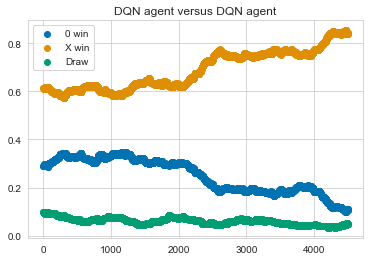

In [55]:
results = battle(env, agent, agent, n_games=20000, title="DQN agent versus DQN agent")

In [56]:
torch.save(agent.model, "./dqn_model.pth")

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 100 игр: выигрышей = 66, 
            ничьих = 2
Эпизод[0] Нолики против рандома 100 игр: выигрышей = 40, 
            ничьих = 1
Эписолн для крестиков и ноликов  0.8179069375972307   0.8179069375972307
Эпизод[2000] Крестики против рандома 100 игр: выигрышей = 99, 
            ничьих = 0
Эпизод[2000] Нолики против рандома 100 игр: выигрышей = 91, 
            ничьих = 3
Эписолн для крестиков и ноликов  0.6689717585696803   0.6689717585696803
Эпизод[4000] Крестики против рандома 100 игр: выигрышей = 98, 
            ничьих = 1
Эпизод[4000] Нолики против рандома 100 игр: выигрышей = 86, 
            ничьих = 5
Эписолн для крестиков и ноликов  0.5471566423907612   0.5471566423907612
Эпизод[6000] Крестики против рандома 100 игр: выигрышей = 99, 
            ничьих = 1
Эпизод[6000] Нолики против рандома 100 игр: выигрышей = 87, 
            ничьих = 3
Эписолн для крестиков и ноликов  0.44752321376381066   0.4475232

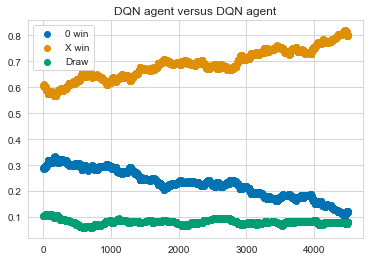

In [57]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
agent1 = DQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-4)
agent2 = DQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-4)
results_1 = battle(env, agent1, agent2, n_games=20000, title="DQN agent versus DQN agent")

In [58]:
torch.save(agent1.model, "./dqn_model_agent1_1.pth")
torch.save(agent2.model, "./dqn_model_agent2_1.pth")

### Вывод

Кажется, если обучать отдельные сети для крестиков и ноликов, то работает лучше.

In [59]:
class DDQNNetwork(nn.Module):
    """
    Dueling DQN Network
    Убрал батч норм, чтобы не делать self.model.eval() и self.model.train(). Возможно, из-за них модель работает медленно.
    """
    def __init__(self, hidden_channels=10):
        nn.Module.__init__(self)
        self.l1 = nn.Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.l3 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.advantage = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=3, padding=1)
        self.value = nn.Conv2d(in_channels=hidden_channels, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        feature = F.relu(self.l3(x))
        value = self.value(feature.mean(dim=(-2, -1), keepdim=True))
        advantage = self.advantage(feature)
        x = value + (advantage - advantage.mean(dim=(-2, -1), keepdim=True))
        return x
    
class DDDQNTicTacAgent():
    """
    Double dueling DQN
    """
    def __init__(self, learning_rate=1e-3, n_rows=3, n_cols=3):
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = DDQNNetwork(hidden_channels=10).to(self.device)
        self.target_model = DDQNNetwork(hidden_channels=10).to(self.device)
        self.crosses_memory = [ReplayMemory(2000), ReplayMemory(2000), ReplayMemory(2000)]
        self.noughts_memory = [ReplayMemory(2000), ReplayMemory(2000), ReplayMemory(2000)]
        self.optimizer = optim.Adam(self.model.parameters(), learning_rate, weight_decay=1e-6)
        self.steps_done = { -1: 0, 1: 0 }
        
        self.trainable = True
        self.gamma = 0.99
        self.batch_size = 256 * 3
        self.sync_target_steps = 2000 
        
        self.eps, self.eps_final, self.eps_step, self.eps_decay = { -1: 1.0, 1: 1.0 }, 0.05, 100, 0.99
        self.sessions = { -1: [], 1: [] }
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.cross_losses = []
        self.nought_losses = []
        
    def getSideFromState(self, state):
        if (np.sum(state == 0) % 2 == (self.n_rows * self.n_cols) % 2):
            return 1
        else:
            return -1
        
    def getActionGreedy(self, state, actions):
        """
        Возвращем индекс лучшего действия
        """
        side = self.getSideFromState(state)
        state = self.convertState(state)
        with torch.no_grad():
            Q_state = self.model(state.to(self.device))[0, 0].detach().cpu().numpy()
        indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
        Q_values = np.take(Q_state, indeces)
        if side == 1:
            action_index = np.argmax(Q_values)
        else:
            action_index = np.argmin(Q_values)
        return actions[action_index]
    
    @property
    def Q(self):
        """
        Возвращаем Q таблицу
        """
        return model_dict(self.model, self.convertState)
    
    def getAction(self, state, actions, side):
        """
        Возвращает позицию на которую нужно поставить крестик/нолик.
        Действие выбираем с учетом эпсилон.
        """
        # облегчил логику то как выбирается действие (чтобы ускорить подсчет)
        random_value = random.random()
        if random_value < self.eps[side]:
            action_index = random.randrange(len(actions))
        else:
            with torch.no_grad():
                Q_state = self.model(state.to(self.device))[0, 0].detach().cpu().numpy()
            # ищем индекс где
            indeces = np.ravel_multi_index((actions[:, 0], actions[:, 1]), dims=(self.n_rows, self.n_cols))
            Q_values = np.take(Q_state, indeces)
            if side == 1:
                action_index = np.argmax(Q_values)
            else:
                action_index = np.argmin(Q_values)
        return actions[action_index]
        
    def convertState(self, state):
        convertedState = torch.tensor(state, dtype=torch.float32)[None, None, :, :]
        return convertedState
    
    def checkSessionHistory(self, side):
        if len(self.sessions[side]) == 2:
            # если в истории сесии есть два события, то добавим их в память
            state, action, _ = self.sessions[side][0]
            self.sessions[side] = self.sessions[side][1:]
            next_state, _, reward = self.sessions[side][0]

            action = self.n_rows * action[0] + action[1]
            action = torch.tensor([action])[None, :]
            reward = torch.tensor([reward])[None, :]

            record = (state, action, next_state, reward)
            if side == 1:
                self.crosses_memory[reward[0] + 1].push(*record)
            else:
                self.noughts_memory[reward[0] + 1].push(*record)
    
    def move(self, env, side):
        state, actions = env.board, env.getEmptySpaces()
        state = self.convertState(state)
        action = self.getAction(state, actions, side)
        _, reward, done, _ = env.step(action)
        # добавляем новую тройку в историю сесии
        self.sessions[side].append((state, action, 0))
        self.checkSessionHistory(side)
        if self.trainable:
            self.learn(side)
        return reward, done
    
    def learn(self, side, reward=False):
        if side == 1:
            memory = self.crosses_memory
        else:
            memory = self.noughts_memory
        if (len(memory[0]) < 2 * self.batch_size) or (len(memory[1]) < 2 * self.batch_size) or (len(memory[2]) < 2 * self.batch_size):
            return
        # берём мини-батч из памяти
        transitions = [memory[i].sample(self.batch_size // 3) for i in range(3)]
        transitions = [x for arr in transitions for x in arr]
        batch = Transition(*zip(*transitions))
        batch_state = Variable(torch.cat(batch.state)).to(self.device)
        batch_action = Variable(torch.cat(batch.action)).to(self.device)
        batch_reward = Variable(torch.cat(batch.reward)).to(self.device)
        batch_next_state = Variable(torch.cat(batch.next_state)).to(self.device)
        # считаем значения функции Q
        Q = self.model(batch_state).view(self.batch_size, -1).gather(1, batch_action).reshape([self.batch_size])
        # оцениваем ожидаемые значения после этого действия
        with torch.no_grad():
            Qmax = self.target_model(batch_next_state).detach()
        if side == 1:
            Qmax[batch_next_state != 0] = -10**9
            Qmax = Qmax.view(self.batch_size, -1).max(1)[0]
        else:
            Qmax[batch_next_state != 0] = 10**9
            Qmax = Qmax.view(self.batch_size, -1).min(1)[0]
        Qmax[batch_reward.view(-1) != 0] = 0
        Qnext = batch_reward.reshape([self.batch_size]) + (self.gamma * Qmax)
        Qnext = torch.clamp(Qnext, -1, 1)
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)
        if side == 1:
            self.cross_losses.append(loss.item())
        else:
            self.nought_losses.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def newGame(self, side):
        self.steps_done[side] += 1
        if self.steps_done[side] % self.eps_step == 0:
            self.eps[side] *= self.eps_decay
            self.eps[side] = max(self.eps[side], self.eps_final)
        if (self.steps_done[1] % self.sync_target_steps == 0) or (self.steps_done[-1] % self.sync_target_steps == 0):
            self.target_model.load_state_dict(self.model.state_dict())
        self.sessions[side] = []
        return side
    
    def endGame(self, env, result, side):
        state = env.board
        state = self.convertState(state)
        # добавить новое состояние в сессию
        self.sessions[side].append((state, None, result))
        # сформировать новую пару ('state', 'action', 'next_state', 'reward') и добавить ее в replay
        self.checkSessionHistory(side)
        # обучиться если можно
        if self.trainable:
            self.learn(side)
        # удалить сессию
        self.sessions[side] = []

In [60]:
def battle(env, player1, player2, n_games=100000, title="DQN agent versus DQN agent"):
    n_dots = min(5000, n_games)
    window_size = 500
    step_size = n_games // n_dots
    results = []
    for i in tqdm(range(n_games)):
        result = play_game(env, player1, player2)
        if i % step_size == 0:
            results.append(result)

        if i % (n_games // 10) == 0:
            print("Эписолн для крестиков и ноликов ", player1.eps[1], " ", player2.eps[-1])
            crosses_rewards = np.array([play_game(env, player1, None, training=False) for i in range(100)])
            print(f"""Эпизод[{i}] Крестики против рандома 100 игр: выигрышей = {int(np.sum(crosses_rewards == 1))}, 
            ничьих = {int(np.sum(crosses_rewards == 0))}""")
            noughts_rewards = np.array([play_game(env, None, player2, training=False) for i in range(100)])
            print(f"""Эпизод[{i}] Нолики против рандома 100 игр: выигрышей = {int(np.sum(noughts_rewards == -1))}, 
            ничьих = {int(np.sum(noughts_rewards == 0))}""")
         
    results = np.array(results, dtype=int)
    results_ = [('0 win', np.array(results == -1, dtype=int)), ('X win', np.array(results == 1, dtype=int)), 
             ('Draw', np.array(results == 0, dtype=int))]
    for result in results_:
        y = np.convolve(result[1], np.ones(window_size) / window_size, mode='valid')
        plt.scatter(np.arange(y.shape[0]), y)
    plt.legend([result[0] for result in results_], loc='upper left')
    plt.title(title)
    plt.show()
    return results

In [61]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
d_agent1 = DDDQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-4)
d_agent2 = DDDQNTicTacAgent(n_rows=3, n_cols=3, learning_rate=1e-4)
d_agent1.device, d_agent2.device

(device(type='cuda'), device(type='cuda'))

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 100 игр: выигрышей = 66, 
            ничьих = 4
Эпизод[0] Нолики против рандома 100 игр: выигрышей = 38, 
            ничьих = 2
Эписолн для крестиков и ноликов  0.7397003733882802   0.7397003733882802
Эпизод[3000] Крестики против рандома 100 игр: выигрышей = 54, 
            ничьих = 8
Эпизод[3000] Нолики против рандома 100 игр: выигрышей = 45, 
            ничьих = 3
Эписолн для крестиков и ноликов  0.5471566423907612   0.5471566423907612
Эпизод[6000] Крестики против рандома 100 игр: выигрышей = 99, 
            ничьих = 1
Эпизод[6000] Нолики против рандома 100 игр: выигрышей = 90, 
            ничьих = 1
Эписолн для крестиков и ноликов  0.4047319726783239   0.4047319726783239
Эпизод[9000] Крестики против рандома 100 игр: выигрышей = 96, 
            ничьих = 4
Эпизод[9000] Нолики против рандома 100 игр: выигрышей = 87, 
            ничьих = 4
Эписолн для крестиков и ноликов  0.29938039131233124   0.2993803

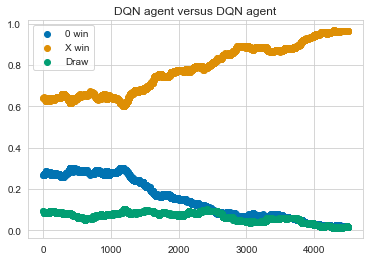

In [62]:
results_2 = battle(env, d_agent1, d_agent2, n_games=30000, title="DQN agent versus DQN agent")

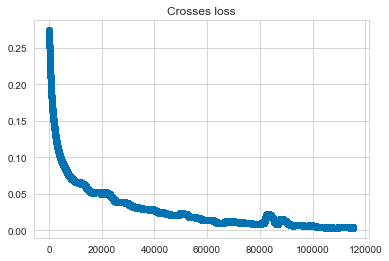

In [63]:
window_size = 1000
y = np.convolve(np.array(d_agent1.cross_losses), np.ones(window_size) / window_size, mode='valid')
plt.scatter(np.arange(y.shape[0]), y)
plt.title("Crosses loss")
plt.show()

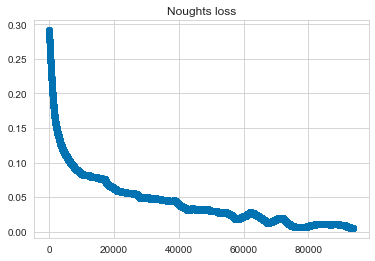

In [64]:
window_size = 1000
y = np.convolve(np.array(d_agent2.nought_losses), np.ones(window_size) / window_size, mode='valid')
plt.scatter(np.arange(y.shape[0]), y)
plt.title("Noughts loss")
plt.show()

In [65]:
torch.save(d_agent1.model, "./dqn_model_d_agent1_1.pth")
torch.save(d_agent2.model, "./dqn_model_d_agent2_1.pth")

Доска 5 на 5

In [66]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=3)
d_agent1 = DDDQNTicTacAgent(n_rows=5, n_cols=5, learning_rate=1e-4)
d_agent2 = DDDQNTicTacAgent(n_rows=5, n_cols=5, learning_rate=1e-4)
d_agent1.device, d_agent2.device

(device(type='cuda'), device(type='cuda'))

Эписолн для крестиков и ноликов  1.0   1.0
Эпизод[0] Крестики против рандома 100 игр: выигрышей = 79, 
            ничьих = 0
Эпизод[0] Нолики против рандома 100 игр: выигрышей = 75, 
            ничьих = 0
Эписолн для крестиков и ноликов  0.7397003733882802   0.7397003733882802
Эпизод[3000] Крестики против рандома 100 игр: выигрышей = 81, 
            ничьих = 0
Эпизод[3000] Нолики против рандома 100 игр: выигрышей = 79, 
            ничьих = 0
Эписолн для крестиков и ноликов  0.5471566423907612   0.5471566423907612
Эпизод[6000] Крестики против рандома 100 игр: выигрышей = 100, 
            ничьих = 0
Эпизод[6000] Нолики против рандома 100 игр: выигрышей = 99, 
            ничьих = 0
Эписолн для крестиков и ноликов  0.4047319726783239   0.4047319726783239
Эпизод[9000] Крестики против рандома 100 игр: выигрышей = 100, 
            ничьих = 0
Эпизод[9000] Нолики против рандома 100 игр: выигрышей = 95, 
            ничьих = 0
Эписолн для крестиков и ноликов  0.29938039131233124   0.29938

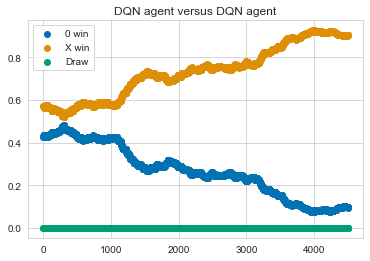

In [67]:
results_3 = battle(env, d_agent1, d_agent2, n_games=30000, title="DQN agent versus DQN agent")

In [68]:
torch.save(d_agent1.model, "./dqn_model_5_d_agent1_1.pth")
torch.save(d_agent2.model, "./dqn_model_5_d_agent2_1.pth")

# Вывод

Судя по графикам обучения Double Dueling DQN обучается быстрее чем обычный DQN (доска 3 на 3).


Благодяра DD DQN смог легко обучить агента играть на доске 5 на 5. Обычный табличный Q-learning не смог нормально научиться (учиться сильно дольше).